# Setting up

In [ ]:
%cd /content/drive/MyDrive/rcnn/

/content/drive/MyDrive/rcnn


In [ ]:
%ls

dataset/  data.zip  drive/  sample_data/


In [ ]:
%%bash
zip -r data.zip dataset
cp -i /content/data.zip /content/drive/MyDrive/rcnn

Process is terminated.


In [ ]:
%%bash
cp -i /content/drive/MyDrive/rcnn/data_v5.zip /content
unzip /content/data_v5.zip -d /content

# Building dataset for classification

In [ ]:
from utils import iou
from config import config
import build_dataset
from imutils import paths

In [ ]:
# grab all image paths in the input images directory
train_pos_imagePaths = list(paths.list_images(config.ORIG_TRAIN_POS_PATH))
test_pos_imagePaths = list(paths.list_images(config.ORIG_TEST_POS_PATH))

In [ ]:
build_dataset.build(train_pos_imagePaths, config.ORIG_TRAIN_ANNOT_PATH, 
                    config.TRAIN_ANNOT_DICT_PATH, config.TRAIN_POS_PATH,
                    config.TRAIN_NEG_PATH)

In [ ]:
build_dataset.build(test_pos_imagePaths, config.ORIG_TEST_ANNOT_PATH, 
                    config.TEST_ANNOT_DICT_PATH, config.TEST_POS_PATH,
                    config.TEST_NEG_PATH)

# Classifier

Found 6394 files belonging to 2 classes.
Using 5116 files for training.
Found 6394 files belonging to 2 classes.
Using 1278 files for validation.
9412608/9406464 [==============================] - 0s 0us/step
[INFO] compiling model...
[INFO] training head...
Epoch 1/50
20/20 [==============================] - 32s 478ms/step - loss: 0.4522 - tp: 199.6190 - fp: 56.6190 - tn: 2149.4286 - fn: 397.7619 - accuracy: 0.8244 - precision: 0.6922 - recall: 0.2767 - auc: 0.7900 - val_loss: 0.2492 - val_tp: 63.0000 - val_fp: 2.0000 - val_tn: 998.0000 - val_fn: 215.0000 - val_accuracy: 0.8302 - val_precision: 0.9692 - val_recall: 0.2266 - val_auc: 0.9587
Epoch 2/50
20/20 [==============================] - 13s 469ms/step - loss: 0.1687 - tp: 364.7143 - fp: 28.3333 - tn: 2184.8571 - fn: 225.5238 - accuracy: 0.9062 - precision: 0.9271 - recall: 0.5982 - auc: 0.9734 - val_loss: 0.1793 - val_tp: 125.0000 - val_fp: 7.0000 - val_tn: 993.0000 - val_fn: 153.0000 - val_accuracy: 0.8748 - val_precision: 0.9470

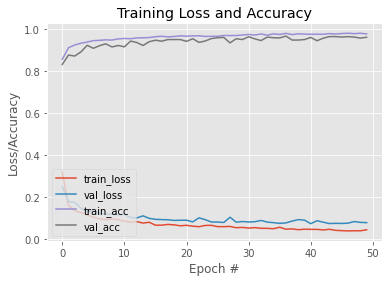

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation  
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras import Input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.metrics import TruePositives
from tensorflow.keras.metrics import FalsePositives
from tensorflow.keras.metrics import TrueNegatives
from tensorflow.keras.metrics import FalseNegatives
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import Recall
from tensorflow.keras.metrics import AUC
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import os

# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-3
EPOCHS = 50
BS = 256

BUFFER_SIZE = BS*5
train_dataset = image_dataset_from_directory('/content/dataset/Train',
                                             validation_split=0.2,
                                             subset="training",
                                             seed=123,
                                             image_size=config.INPUT_DIMS,
                                             batch_size=BS)
validation_dataset = image_dataset_from_directory('/content/dataset/Train',
                                                  validation_split=0.2,
                                                  subset="validation",
                                                  seed=123,
                                                  image_size=config.INPUT_DIMS,
                                                  batch_size=BS)

#train_dataset = train_dataset.cache().prefetch(buffer_size=BUFFER_SIZE)
#validation_dataset = validation_dataset.cache().prefetch(buffer_size=
#                                                         BUFFER_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=BUFFER_SIZE)
validation_dataset = validation_dataset.prefetch(buffer_size=
                                                        BUFFER_SIZE)
#test_dataset = train_dataset.cache().prefetch(buffer_size=BUFFER_SIZE)

# process data
data_augmentation = Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.2),
    Rescaling(1./127.5, offset= -1)
])

# construct the input player and appy 
inputs = Input(shape=(224, 224, 3))
headModel = data_augmentation(inputs)

# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
                     input_shape=(224, 224, 3))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel(headModel)
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(1, activation='sigmoid')(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=inputs, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

METRICS = [TruePositives(thresholds=0.8, name='tp'), 
           FalsePositives(thresholds=0.8, name='fp'),
           TrueNegatives(thresholds=0.8, name='tn'),
           FalseNegatives(thresholds=0.8, name='fn'), 
           BinaryAccuracy(threshold=0.8, name='accuracy'),
           Precision(thresholds=0.8, name='precision'),
           Recall(thresholds=0.8, name='recall'),
           AUC(name='auc')]

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR)
model.compile(loss=BinaryCrossentropy(), optimizer=opt,
	metrics=METRICS)
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	train_dataset,
	validation_data=validation_dataset,
	epochs=EPOCHS)

# evaluate the model
print("[INFO] evaluating model...")
#model.evaluate(test_dataset)

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save(os.path.sep.join([config.MODEL_PATH, 
                             "human_detector_MobileNetV2_v6.h5"]), 
                             save_format="h5")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(os.path.sep.join([config.PLOT_PATH, 
                              "plot_MobileNetV2_v6.png"]))


# Inference 1

[INFO] loading model and label binarizer...
(580, 722, 3)
[INFO] running selective search...
[INFO] proposal shape: (2300, 224, 224, 3)
[INFO] classifying proposals...
[INFO] applying NMS...


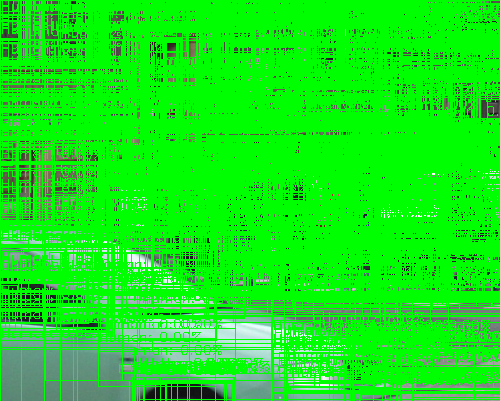

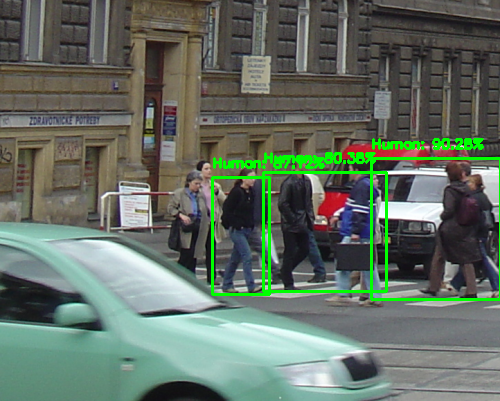

In [ ]:
# import the necessary packages
from config import config
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from tensorflow.image import non_max_suppression_with_scores
from tensorflow import convert_to_tensor
from google.colab.patches import cv2_imshow
import numpy as np
import argparse
import imutils
import pickle
import cv2

print("[INFO] loading model and label binarizer...")
model = load_model('/content/drive/MyDrive/rcnn/models/human_detector_MobileNetV2_v6.h5')

# load the input image from disk
#image = cv2.imread('/content/drive/MyDrive/rcnn/INRIAPerson/Train/pos/crop001003.png')
image = cv2.imread('/content/drive/MyDrive/rcnn/INRIAPerson/Test/pos/crop001593.png')
print(image.shape)
image = imutils.resize(image, width=500)

# run selective search on the image to generate bounding box proposal
# regions
print("[INFO] running selective search...")
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
rects = ss.process()

# initialize the list of region proposals that we'll be classifying
# along with their associated bounding boxes
proposals = []
boxes = []
# loop over the region proposal bounding box coordinates generated by
# running selective search
for (x, y, w, h) in rects[:4000]:
	# extract the region from the input image, convert it from BGR to
	# RGB channel ordering, and then resize it to the required input
	# dimensions of our trained CNN
	roi = image[y:y + h, x:x + w]
	roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
	roi = cv2.resize(roi, config.INPUT_DIMS,
		interpolation=cv2.INTER_CUBIC)
	# further preprocess the ROI
	roi = img_to_array(roi)
	# update our proposals and bounding boxes lists
	proposals.append(roi)
	boxes.append((x, y, x + w, y + h))

# convert the proposals and bounding boxes into NumPy arrays
proposals = np.array(proposals, dtype="float32")
boxes = np.array(boxes, dtype="int32")
print("[INFO] proposal shape: {}".format(proposals.shape))
# classify each of the proposal ROIs using fine-tuned model
print("[INFO] classifying proposals...")
proba = model.predict(proposals)
proba = proba.flatten()

print("[INFO] applying NMS...")
# clone the original image so that we can draw on it
clone = image.copy()
# loop over the bounding boxes and associated probabilities
for (box, prob) in zip(boxes, proba):
	# draw the bounding box, label, and probability on the image
  (startX, startY, endX, endY) = box
  cv2.rectangle(clone, (startX, startY), (endX, endY),
		(0, 255, 0), 1)
  y = startY - 10 if startY - 10 > 10 else startY + 10
  text= "Human: {:.2f}%".format(prob * 100)
  cv2.putText(clone, text, (startX, y),
              cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 1)
# show the output after *before* running NMS
cv2_imshow(clone)

#idxs = non_max_suppression_with_scores(boxes, 
#                                       convert_to_tensor(proba), 
#                                       max_output_size=20,
#                                       iou_threshold=0.9,
#                                       score_threshold=0.8,
#                                       soft_nms_sigma=.5)[0]

idxs = non_max_suppression_with_scores(boxes, 
                                       convert_to_tensor(proba), 
                                       max_output_size=10,
                                       iou_threshold=0.2,
                                       score_threshold=0.8,
                                       soft_nms_sigma=0.5)[0]
boxes = boxes[idxs.numpy()]
proba = proba[idxs.numpy()]

# loop over the bounding box indexes
for (i, box) in enumerate(boxes):
	# draw the bounding box, label, and probability on the image
	(startX, startY, endX, endY) = box
	cv2.rectangle(image, (startX, startY), (endX, endY),
		(0, 255, 0), 2)
	y = startY - 10 if startY - 10 > 10 else startY + 10
	text= "Human: {:.2f}%".format(proba[i] * 100)
	cv2.putText(image, text, (startX, y),
		cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
# show the output image *after* running NMS
cv2_imshow(image)


In [ ]:
proba

array([0.993491  , 0.98519474, 0.97341985, 0.9851171 ], dtype=float32)

In [ ]:
test_dataset = image_dataset_from_directory('/content/dataset/Test',
                                                  seed=123,
                                                  image_size=config.INPUT_DIMS,
                                                  batch_size=BS)
test_dataset = train_dataset.cache().prefetch(buffer_size=BUFFER_SIZE)
model.evaluate(test_dataset)

Found 1042 files belonging to 2 classes.
54/54 [==============================] - 5s 95ms/step - loss: 0.0662 - tp: 420.0000 - fp: 14.0000 - tn: 6300.0000 - fn: 101.0000 - accuracy: 0.9832 - precision: 0.9677 - recall: 0.8061 - auc: 0.9730


[0.0661795511841774,
 420.0,
 14.0,
 6300.0,
 101.0,
 0.9831748604774475,
 0.9677419066429138,
 0.8061420321464539,
 0.9729993939399719]

# Building dataset for bounding box regression

In [ ]:
from utils import iou
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from tensorflow.image import non_max_suppression_with_scores
from tensorflow import convert_to_tensor
import numpy as np
import argparse
import imutils
import pickle
import cv2
import gc

def transform_box(box, ratio_x, ratio_y):
  xMin, yMin, xMax, yMax = box
  return (int(xMin/ratio_x), int(yMin/ratio_y),
          int(xMax/ratio_x), int(yMax/ratio_y))

train_annot_dict = {}
with open(config.TRAIN_ANNOT_DICT_PATH, "rb") as f:
  train_annot_dict = pickle.load(f)

data = {}
images_lst = []
boxes_lst =  []
gtBoxes_lst = []
proposals_lst = []
transformations_lst = []

model = load_model('/content/drive/MyDrive/rcnn/models/human_detector_MobileNetV2_2.h5')

for (i, imagePath) in enumerate(train_pos_imagePaths):
  print("[INFO] processing positive image {}/{}...".format(i + 1,
                                                    len(train_pos_imagePaths)))
  image = cv2.imread(imagePath)
  img_arr = img_to_array(cv2.resize(image, config.INPUT_DIMS,
      interpolation=cv2.INTER_CUBIC))

  # run selective search on the image to generate bounding box proposal
  # regions
  ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
  ss.setBaseImage(image)
  ss.switchToSelectiveSearchFast()
  rects = ss.process()

  # initialize the list of region proposals that we'll be classifying
  # along with their associated bounding boxes
  proposals = []
  boxes = []
  # loop over the region proposal bounding box coordinates generated by
  # running selective search
  for (x, y, w, h) in rects[:config.MAX_PROPOSALS]:
    # extract the region from the input image, convert it from BGR to
    # RGB channel ordering, and then resize it to the required input
    # dimensions of our trained CNN
    roi = image[y:y + h, x:x + w]
    roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
    roi = cv2.resize(roi, config.INPUT_DIMS,
      interpolation=cv2.INTER_CUBIC)
    # further preprocess the ROI
    roi = img_to_array(roi)
    # update our proposals and bounding boxes lists
    proposals.append(roi)
    boxes.append((x, y, x + w, y + h))
  del image
  gc.collect()
  # convert the proposals and bounding boxes into NumPy arrays
  proposals = np.array(proposals, dtype="float32")
  boxes = np.array(boxes, dtype="int32")

  # classify each of the proposal ROIs using fine-tuned model
  proba = model.predict(proposals)
  proba = proba.flatten()


  idxs = non_max_suppression_with_scores(boxes, 
                                        convert_to_tensor(proba), 
                                        max_output_size=20,
                                        iou_threshold=0.9,
                                        score_threshold=0.4,
                                        soft_nms_sigma=0.5)[0]

  boxes = boxes[idxs.numpy()]
  proba = proba[idxs.numpy()]
  proposals = proposals[idxs.numpy()]

  gtBoxes = train_annot_dict[imagePath]['gtBoxes']
  w = train_annot_dict[imagePath]['w']
  h = train_annot_dict[imagePath]['h']
  ratio_x, ratio_y = w/(config.INPUT_DIMS[0]*1.0), h/(config.INPUT_DIMS[1]*1.0)
  for gtBox in gtBoxes:
    bestBox = []
    best_iou = 0
    idx = None
    for i, box in enumerate(boxes):
      iou_ = iou.compute_iou(gtBox, box)
      if iou_ > best_iou and iou_ > 0.7:
        bestBox = box
        best_iou = iou_
        idx = i
    if best_iou > 0.7:
      images_lst.append(img_arr)
      proposals_lst.append(proposals[i])
      boxes_lst.append(transform_box(bestBox, ratio_x, ratio_y))
      gtBoxes_lst.append(transform_box(gtBox, ratio_x, ratio_y))
      transformation.append(((gtBox[0]-box[0])/box[2], (gtBox[1]-box[1])/box[3], math.log(gtBox[2]/box[2]), math.log(gtBox[3]/box[3])))
      print("Found a box")
  del proposals
  gc.collect()

In [ ]:
import numpy as np

with open(config.TEST_PATH + '/images_BR_v4.npy', 'wb') as f:
  np.save(f, images_lst)

with open(config.TEST_PATH + '/boxes_BR_v3.npy', 'wb') as f:
  np.save(f, boxes_lst)

with open(config.TEST_PATH + '/gtBoxes_BR_v3.npy', 'wb') as f:
  np.save(f, gtBoxes_lst)

with open(config.TRAIN_PATH + '/proposals_BR_v5.npy', 'wb') as f:
  np.save(f, proposals_lst)

with open(config.TRAIN_PATH + '/transformation_BR_v5.npy', 'wb') as f:
  np.save(f, transformations_lst)

# Bounding box

In [ ]:
import tensorflow as tf

class Smooth_L1_Loss(tf.losses.Loss):
    """Implements Smooth L1 loss"""

    def __init__(self, delta):
        super(Smooth_L1_Loss, self).__init__(
            reduction="none", name="Smooth_L1_Loss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)

In [ ]:
from tensorflow.keras import Input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import concatenate
from sklearn.model_selection import train_test_split
import numpy as np

def get_bounding_box_model():
  img_Model = MobileNetV2(weights="imagenet", include_top=False,
                     input_shape=(224, 224, 3))

  # define two sets of inputs
  inputA = Input(shape=(224,224,3)) 



  # the first branch operates on the first input
  #x = img_preprocessing(inputA)
  x = inputA
  x = img_Model(x)
  x = GlobalAveragePooling2D()(x)


  # apply a FC layer and then a regression prediction on the
  # combined outputs
  x = Dense(256, activation="relu")(x)
  x = Dense(32, activation="relu")(x)
  x = Dense(4, activation="linear")(x)

  # the model will accept the inputs of the two branches and
  # then output a single value
  model = Model(inputs=inputA, outputs=x)

  for layer in img_Model.layers:
	  layer.trainable = False

  return model

images = None
boxes= None
gtBoxes = None
proposals = None
transformation = None

with open(config.TRAIN_PATH + '/proposals_BR_v5.npy', 'rb') as f:
  proposals = np.load(f)

with open(config.TRAIN_PATH + '/transformation_BR_v5.npy', 'rb') as f:
  transformation = np.load(f)

proposals = proposals/127.5 - 1

(trainProposals, testProposals, trainTransformation, testTransformation) = \
  train_test_split(proposals, transformation, test_size=0.2, random_state=42)

model = get_bounding_box_model()

opt = Adam(lr=0.0005)
#model.compile(loss=Smooth_L1_Loss(delta=1), optimizer=opt,
#	metrics=['mean_squared_error', 'mean_absolute_error'])
model.compile(loss=['mse'], optimizer=opt,
	metrics=['mean_absolute_error'])

H = model.fit(
	x=trainProposals, y=trainTransformation,
	validation_data=(testProposals, testTransformation),
	epochs=100, batch_size=512)

Epoch 1/100
5/5 [==============================] - 4s 412ms/step - loss: 0.7459 - mean_absolute_error: 0.6914 - val_loss: 0.2290 - val_mean_absolute_error: 0.3895
Epoch 2/100
5/5 [==============================] - 1s 251ms/step - loss: 0.1752 - mean_absolute_error: 0.3312 - val_loss: 0.0955 - val_mean_absolute_error: 0.2461
Epoch 3/100
5/5 [==============================] - 1s 254ms/step - loss: 0.0810 - mean_absolute_error: 0.2238 - val_loss: 0.0631 - val_mean_absolute_error: 0.1938
Epoch 4/100
5/5 [==============================] - 1s 252ms/step - loss: 0.0492 - mean_absolute_error: 0.1711 - val_loss: 0.0396 - val_mean_absolute_error: 0.1566
Epoch 5/100
5/5 [==============================] - 1s 252ms/step - loss: 0.0340 - mean_absolute_error: 0.1461 - val_loss: 0.0322 - val_mean_absolute_error: 0.1440
Epoch 6/100
5/5 [==============================] - 1s 249ms/step - loss: 0.0294 - mean_absolute_error: 0.1375 - val_loss: 0.0245 - val_mean_absolute_error: 0.1252
Epoch 7/100
5/5 [=====

In [ ]:
model.save(os.path.sep.join([config.MODEL_PATH, 
                             "human_detector_BR_v6.h5"]), 
                             save_format="h5")

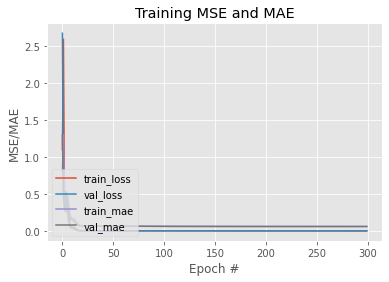

In [ ]:
import matplotlib.pyplot as plt

# plot the training loss and accuracy
N = 300
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["mean_absolute_error"], label="train_mae")
plt.plot(np.arange(0, N), H.history["val_mean_absolute_error"], label="val_mae")
plt.title("Training MSE and MAE")
plt.xlabel("Epoch #")
plt.ylabel("MSE/MAE")
plt.legend(loc="lower left")

# Inference 2

[INFO] loading model and label binarizer...
(609, 1138, 3)
[INFO] running selective search...
[INFO] proposal shape: (5000, 224, 224, 3)
[INFO] classifying proposals...
[INFO] applying NMS...


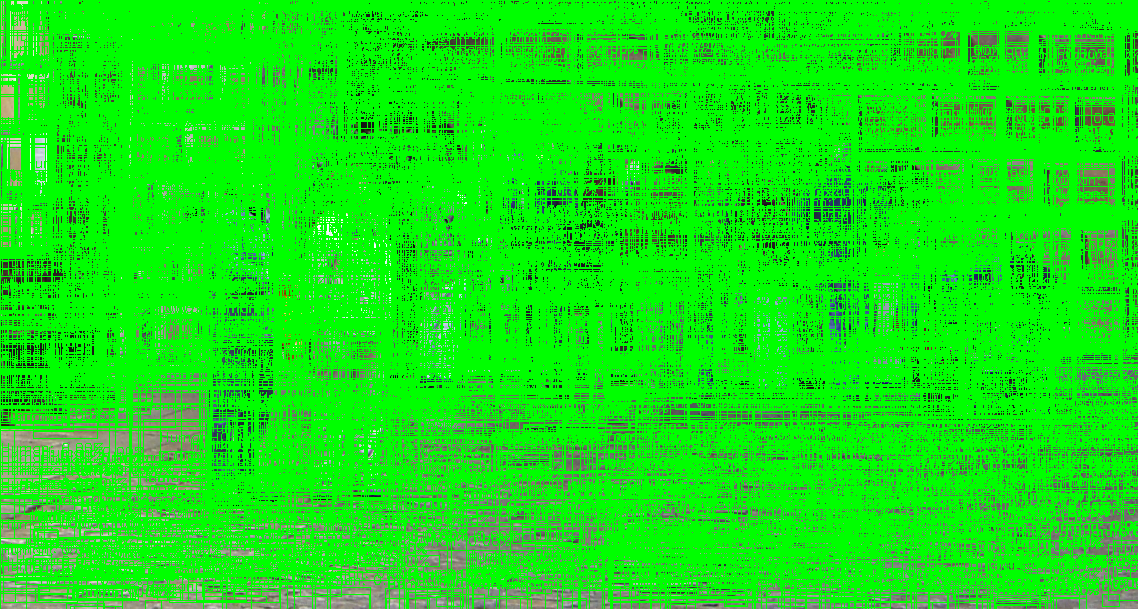

[0.9981645  0.9951441  0.92845136 0.9168578  0.8937565  0.7671614
 0.73166263 0.6751298  0.6553634  0.58674353]
(10, 4)


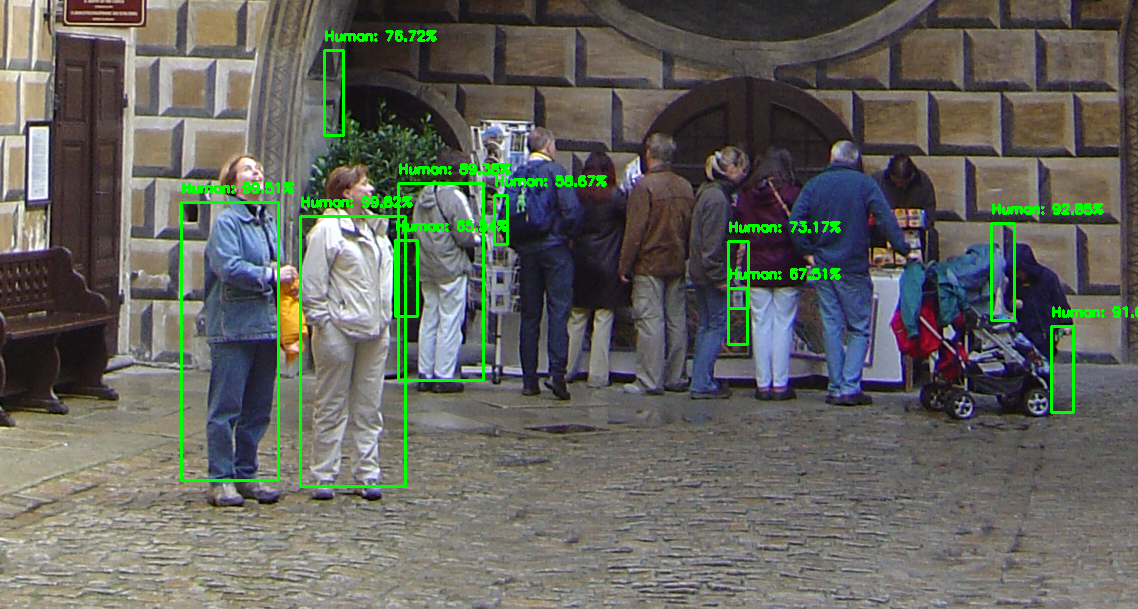

(10, 4)
[[-0.05957007 -0.01714764 -0.00098006 -0.043228  ]
 [-0.07266419  0.00206671  0.01954462 -0.0184253 ]
 [-0.03080034 -0.02483087 -0.00352877 -0.02065151]
 [ 0.0038432  -0.03408276 -0.00659783  0.00653432]
 [ 0.00998939  0.03875361  0.12029148  0.11177718]
 [ 0.03711287 -0.03552547 -0.00037592  0.04925164]
 [ 0.0038432  -0.03408276 -0.00659783  0.00653432]
 [-0.09850134  0.07712765  0.13548796  0.02446443]
 [-0.07811964  0.0364204   0.09345355 -0.00780992]
 [ 0.0154991  -0.03458821 -0.00441801  0.02150017]]
trans [-0.05957007 -0.01714764 -0.00098006 -0.043228  ]
boxes[i] [300 216 405 486]
predicted_boxes[i] (293, 217, 398, 475)
trans [-0.07266419  0.00206671  0.01954462 -0.0184253 ]
boxes[i] [181 202 278 480]
predicted_boxes[i] (172, 205, 271, 478)
trans [-0.03080034 -0.02483087 -0.00352877 -0.02065151]
boxes[i] [ 991  223 1014  320]
predicted_boxes[i] (990, 221, 1013, 316)
trans [ 0.0038432  -0.03408276 -0.00659783  0.00653432]
boxes[i] [1051  326 1073  412]
predicted_boxes[i] (

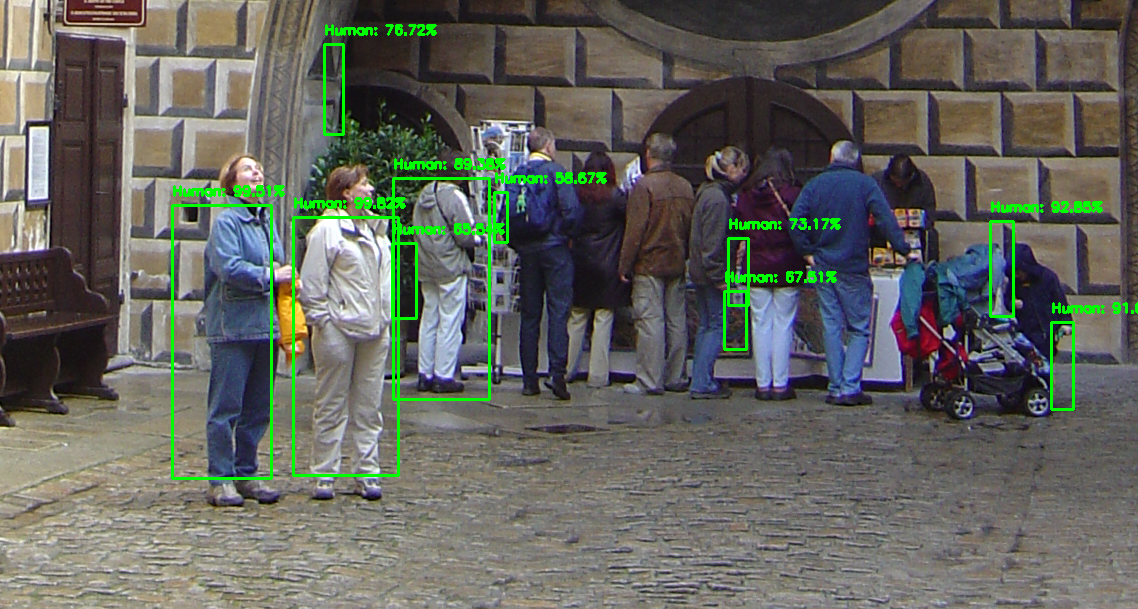

tf.Tensor([0 1 2 3 4], shape=(5,), dtype=int32)
(5, 4)
[[ 293  217  398  475]
 [ 172  205  271  478]
 [ 990  221 1013  316]
 [1051  322 1073  409]
 [ 393  178  489  399]]


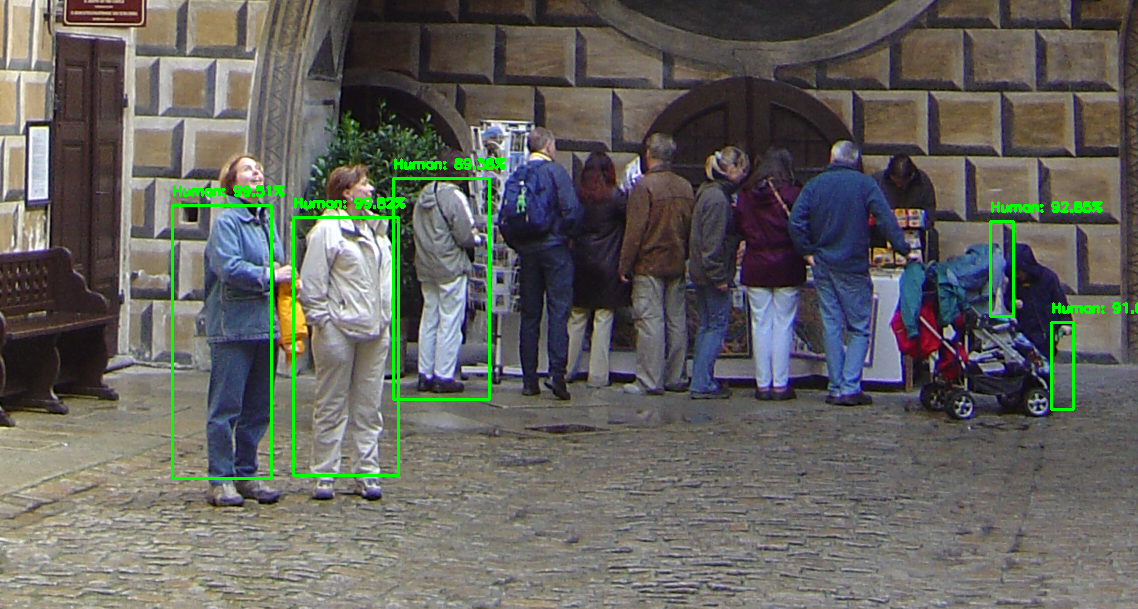

In [ ]:
# import the necessary packages
from config import config
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from tensorflow.image import non_max_suppression_with_scores
from tensorflow import convert_to_tensor
from google.colab.patches import cv2_imshow
import numpy as np
import argparse
import imutils
import pickle
import cv2
import math

def transform_box(box, ratio_x, ratio_y):
  xMin, yMin, xMax, yMax = box
  return (int(xMin/ratio_x), int(yMin/ratio_y),
          int(xMax/ratio_x), int(yMax/ratio_y))

print("[INFO] loading model and label binarizer...")
model1 = load_model('/content/drive/MyDrive/rcnn/models/human_detector_MobileNetV2_v6.h5')
model = load_model('/content/drive/MyDrive/rcnn/models/human_detector_BR_v6.h5')

# load the input image from disk
#image = cv2.imread('/content/drive/MyDrive/rcnn/INRIAPerson/Train/pos/crop001003.png')
image = cv2.imread('/content/drive/MyDrive/rcnn/INRIAPerson/Test/pos/crop001607.png')
print(image.shape)

height = image.shape[0]
width = image.shape[1]


img_arr = img_to_array(cv2.resize(image, config.INPUT_DIMS,
      interpolation=cv2.INTER_CUBIC))
img_arr = np.expand_dims(img_arr, axis=0)

# run selective search on the image to generate bounding box proposal
# regions
print("[INFO] running selective search...")
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
rects = ss.process()

# initialize the list of region proposals that we'll be classifying
# along with their associated bounding boxes
proposals = []
boxes = []
# loop over the region proposal bounding box coordinates generated by
# running selective search
for (x, y, w, h) in rects[:5000]:
	# extract the region from the input image, convert it from BGR to
	# RGB channel ordering, and then resize it to the required input
	# dimensions of our trained CNN
	roi = image[y:y + h, x:x + w]
	roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
	roi = cv2.resize(roi, config.INPUT_DIMS,
		interpolation=cv2.INTER_CUBIC)
	# further preprocess the ROI
	roi = img_to_array(roi)
	# update our proposals and bounding boxes lists
	proposals.append(roi)
	boxes.append((x, y, x + w, y + h))

# convert the proposals and bounding boxes into NumPy arrays
proposals = np.array(proposals, dtype="float32")
boxes = np.array(boxes, dtype="int32")
print("[INFO] proposal shape: {}".format(proposals.shape))
# classify each of the proposal ROIs using fine-tuned model
print("[INFO] classifying proposals...")
proba = model1.predict(proposals)
proba = proba.flatten()

print("[INFO] applying NMS...")
# clone the original image so that we can draw on it
clone = image.copy()
# loop over the bounding boxes and associated probabilities
for (box, prob) in zip(boxes, proba):
	# draw the bounding box, label, and probability on the image
  (startX, startY, endX, endY) = box
  cv2.rectangle(clone, (startX, startY), (endX, endY),
		(0, 255, 0), 1)
  y = startY - 10 if startY - 10 > 10 else startY + 10
  text= "Human: {:.2f}%".format(prob * 100)
  cv2.putText(clone, text, (startX, y),
              cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 1)
# show the output after *before* running NMS
cv2_imshow(clone)

idxs = non_max_suppression_with_scores(boxes, 
                                      convert_to_tensor(proba), 
                                      max_output_size=10,
                                      iou_threshold=0.3,
                                      score_threshold=0.5,
                                      soft_nms_sigma=.5)[0]

# idxs = non_max_suppression_with_scores(boxes, 
#                                        convert_to_tensor(proba.flatten()), 
#                                        max_output_size=10,
#                                        iou_threshold=0.9,
#                                        score_threshold=0.5,
#                                        soft_nms_sigma=.5)[0]

boxes = boxes[idxs.numpy()]
proba = proba[idxs.numpy()]
print(proba)
proposals = proposals[idxs.numpy()]
print(boxes.shape)

clone1 = image.copy()
# loop over the bounding box indexes
for (i, box) in enumerate(boxes):
	# draw the bounding box, label, and probability on the image
	(startX, startY, endX, endY) = box
	cv2.rectangle(clone1, (startX, startY), (endX, endY),
		(0, 255, 0), 2)
	y = startY - 10 if startY - 10 > 10 else startY + 10
	text= "Human: {:.2f}%".format(proba[i] * 100)
	cv2.putText(clone1, text, (startX, y),
		cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
# show the output image *after* running NMS
cv2_imshow(clone1)

boxes = np.reshape(boxes, (-1,4))
print(boxes.shape)

predicted_transformation = model.predict(x=proposals)
print(predicted_transformation)
predicted_boxes = []

clone2 = image.copy()
# loop over the bounding box indexes
for (i, trans) in enumerate(predicted_transformation):
	# draw the bounding box, label, and probability on the image
  print('trans', trans)
  (t_x, t_y, t_w, t_h) = trans
  (startX, startY, endX, endY) = boxes[i]
  print('boxes[i]', boxes[i])
  p_w = endX - startX
  #print('p_w', p_w)
  p_h = endY- startY
  #print('p_h', p_h)
  p_x = (startX + endX)/2
  #print('p_x', p_x)
  p_y = (startY + endY)/2
  #print('p_y', p_y)
  g_x, g_y = t_x*p_w+p_x, t_y*p_h+p_y
  #print('g_x', g_x)
  #print('g_y', g_y)
  g_w, g_h = p_w*math.exp(t_w), p_h*math.exp(t_h)
  #print('g_w', g_w)
  #print('g_h', g_h)
  startX, endX = max(0,int(g_x - g_w/2)), min(width,int(g_x + g_w/2))
  startY, endY = max(0,int(g_y - g_h/2)), min(height,int(g_y + g_h/2))
  predicted_boxes.append((startX, startY, endX, endY))
  print('predicted_boxes[i]', predicted_boxes[-1])
  #startX, endX = int(startX*width/224), int(endX*width/224)
  #startY, endY = int(startY*height/224), int(endY*height/224)
  cv2.rectangle(clone2, (startX, startY), (endX, endY),
               (0, 255, 0), 2)
  y = startY - 10 if startY - 10 > 10 else startY + 10
  text= "Human: {:.2f}%".format(proba[i] * 100)
  cv2.putText(clone2, text, (startX, y),
		cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
# show the output image *after* running NMS
cv2_imshow(clone2)

predicted_boxes = np.array(predicted_boxes)

idxs = non_max_suppression_with_scores(predicted_boxes, 
                                       convert_to_tensor(proba), 
                                       max_output_size=6,
                                       iou_threshold=0.3,
                                       score_threshold=0.8,
                                       soft_nms_sigma=.5)[0]
print(idxs)
predicted_boxes = predicted_boxes[idxs.numpy()]
print(predicted_boxes.shape)
print(predicted_boxes)
proba = proba[idxs.numpy()]

# loop over the bounding box indexes
for (i, box) in enumerate(predicted_boxes):
	# draw the bounding box, label, and probability on the image
  (startX, startY, endX, endY) = box
  #startX, endX = int(startX), int(endX)
  #startY, endY = int(startY), int(endY)
  #startX, endX = int(startX*width/224), int(endX*width/224)
  #startY, endY = int(startY*height/224), int(endY*height/224)
  cv2.rectangle(image, (startX, startY), (endX, endY),
		(0, 255, 0), 2)
  y = startY - 10 if startY - 10 > 10 else startY + 10
  text= "Human: {:.2f}%".format(proba[i] * 100)
  cv2.putText(image, text, (startX, y),
		cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
# show the output image *after* running NMS
cv2_imshow(image)